In [15]:
# change the following to %matplotlib notebook for interactive plotting
%matplotlib inline

import numpy as np
import pandas as pd

import pims
import trackpy as tp
import os

import matplotlib  as mpl 
import matplotlib.pyplot as plt 

import skimage
import skimage.measure
import matplotlib.patches as mpatches

from scipy import ndimage
from skimage import morphology, util, filters

import tifffile as tiffio

import ipywidgets as widgets
from IPython.display import display

# Optionally, tweak styles.
mpl.rc('figure',  figsize=(10, 6))
mpl.rc('image', cmap='gray')

In [18]:
frames = tiffio.imread('/Users/scliu/Dropbox (Personal)/Academics/PhD_phase/Thomson_Lab/local_to_global_pre-print/data/figure_2/stokes/5_6.1_125_min_1.tif')


In [20]:
len(frames)

175

In [99]:
# only want the bf frame
bf_frames = frames[::3]
bf_frames[1]

IndexError: Key out of range

In [58]:
def play_frames(frame_index):
    plt.imshow(bf_frames[frame_index], cmap='gray')
    plt.axis('off')
    plt.show()

frame_slider = widgets.IntSlider(min=0, max=len(bf_frames)-1, step=1, value=0)
widgets.interact(play_frames, frame_index=frame_slider)


interactive(children=(IntSlider(value=0, description='frame_index', max=166), Output()), _dom_classes=('widget…

<function __main__.play_frames(frame_index)>

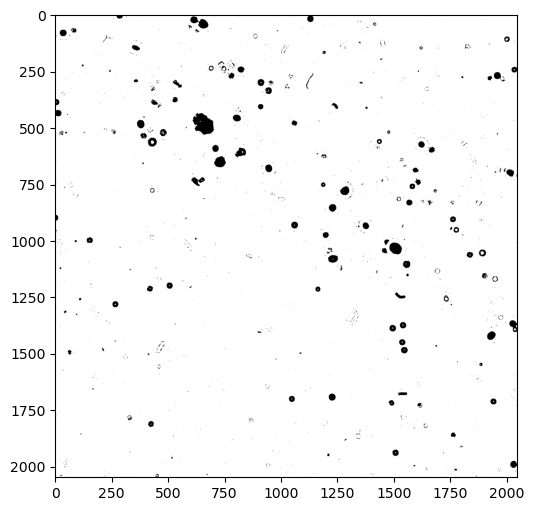

In [64]:
@pims.pipeline
def preprocess_foam(img):
    """
    Apply image processing functions to return a binary image
    """
    # Crop the pictures as for raw images.
    # Apply thresholds
    adaptive_thresh = filters.threshold_local(img,301)
    idx = img < adaptive_thresh
    idx2 = img > adaptive_thresh
    img[idx] = 0
    img[idx2] = 255
    img = ndimage.binary_dilation(img)
    img = ndimage.binary_dilation(img)
    return util.img_as_int(img)


frames_thresh = preprocess_foam(bf_frames)
plt.imshow(frames_thresh[1]);

Found 3200 features


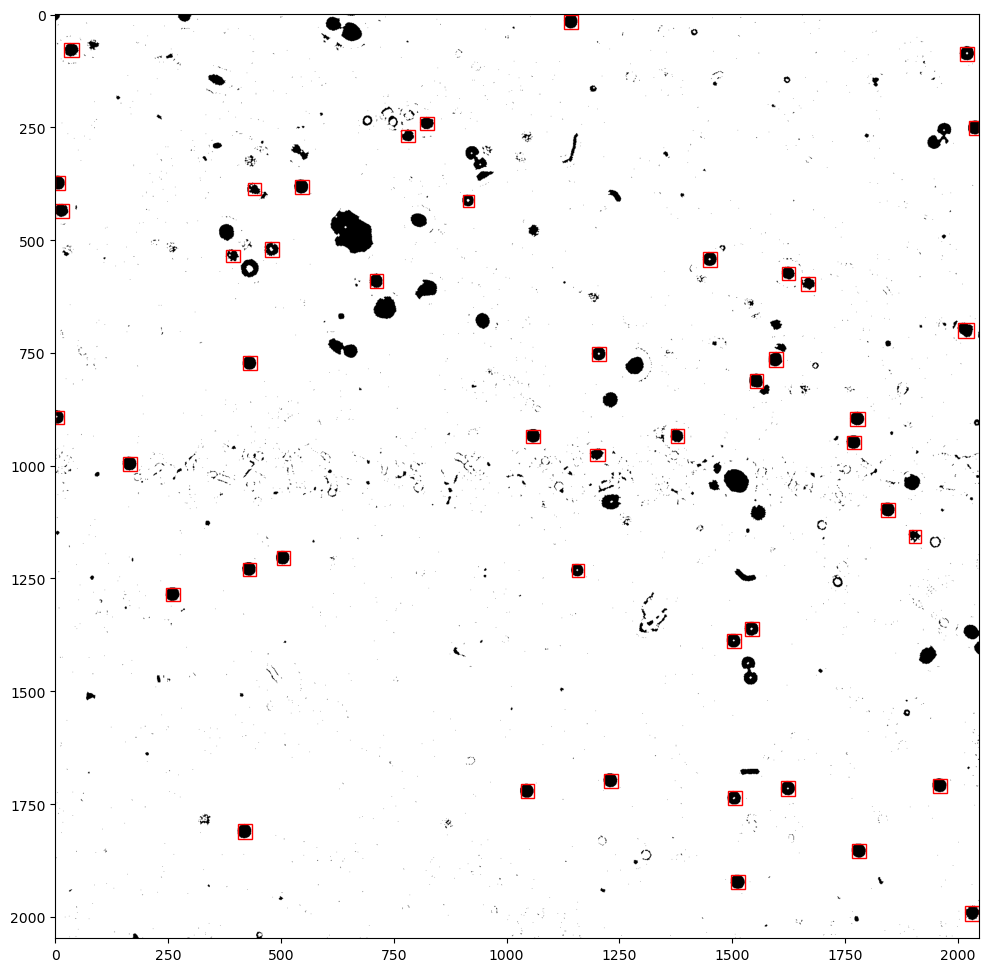

In [75]:
img_example = frames_thresh[57]

# Label elements on the picture
white = 255
label_image, number_of_labels = skimage.measure.label(img_example, background=white, return_num=True)
print("Found %d features"%(number_of_labels))
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(12, 12))
ax.imshow(img_example)
for region in skimage.measure.regionprops(label_image, intensity_image=img_example):
    # Everywhere, skip small and large areas
    if region.area < 400 or region.area > 800:
        continue
    # Only black areas
    if region.mean_intensity > 1:
        continue
    # On the top, skip small area with a second threshold
    if region.centroid[0] > 800 and region.area < 400:
        continue
    # Skip non-rounded features using eccentricity
    max_eccentricity = 0.8  # Adjust this threshold as needed
    if region.eccentricity > max_eccentricity:
        continue

    # Draw rectangle which survived to the criterions
    minr, minc, maxr, maxc = region.bbox
    rect = mpatches.Rectangle((minc, minr), maxc - minc, maxr - minr,
                              fill=False, edgecolor='red', linewidth=1)

    ax.add_patch(rect)

In [76]:

def filter_regions(num, img):
    white = 255
    label_image = skimage.measure.label(img, background=white)
    regions = skimage.measure.regionprops(label_image, intensity_image=img)

    filtered_regions = [
        {
            'y': region.centroid[0],
            'x': region.centroid[1],
            'frame': num
        }
        for region in regions
        if (
            400 <= region.area <= 800 and
            region.mean_intensity <= 1 and
            not (region.centroid[0] > 800 and region.area < 400) and
            region.eccentricity <= 0.8
        )
    ]

    return filtered_regions


filtered_regions_list = [filter_regions(num, img) for num, img in enumerate(frames_thresh)]
features = pd.DataFrame([item for sublist in filtered_regions_list for item in sublist])


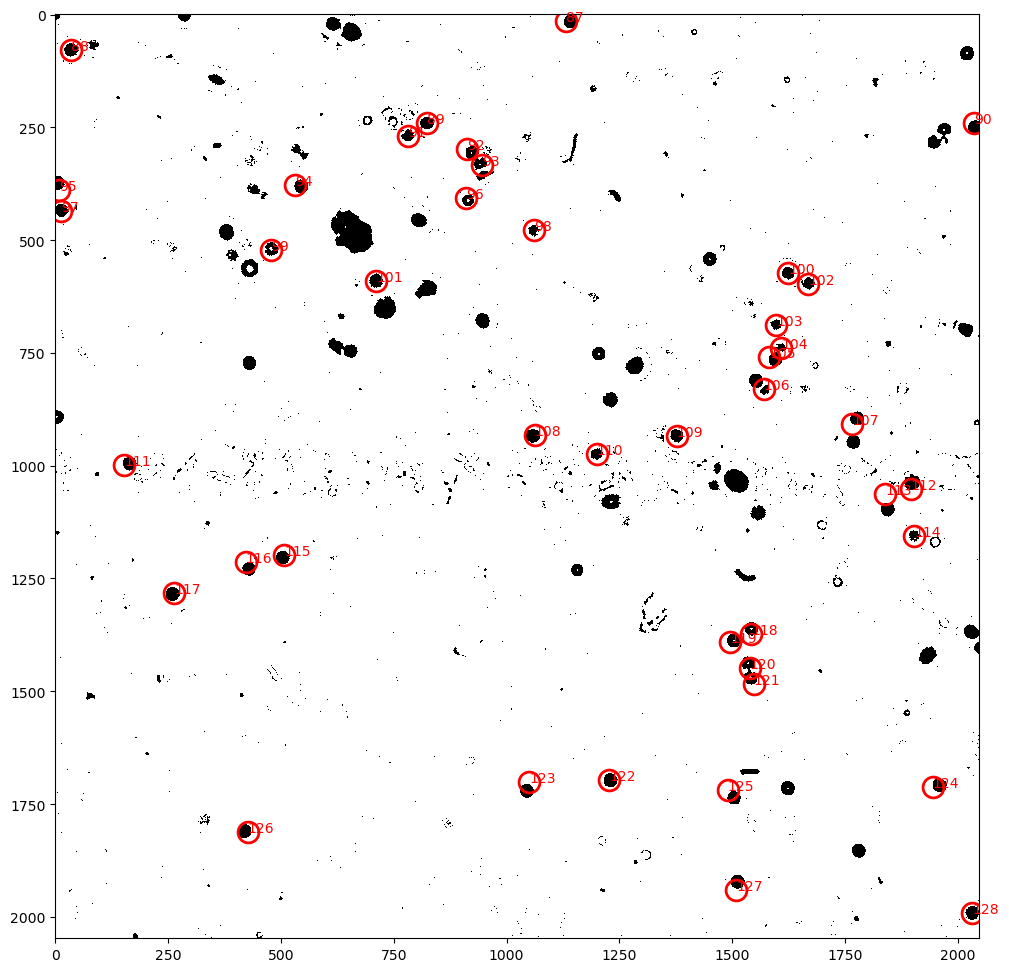

In [77]:
def plot_features_with_labels(frame, features_df, image):
    """
    This function annotates each detected feature with its ID on the plot.

    Parameters:
    frame: The number of the frame you want to plot.
    features_df: A pandas DataFrame that contains the features detected by trackpy.
    image: The image you want to plot the features on.
    """
    # Create a new DataFrame that only contains the features in the frame you're interested in
    frame_features = features_df[features_df.frame==frame]
    
    fig, ax = plt.subplots(figsize=(12, 12))
    ax.imshow(image)
    tp.annotate(frame_features, image, ax=ax)
    
    # Annotate the ID of each feature
    for index, feature in frame_features.iterrows():
        ax.text(feature.x, feature.y, str(index), color='red')

    plt.show()


# Then you would use it like this:
id_example = 1
plot_features_with_labels(id_example+1, features, img_example)

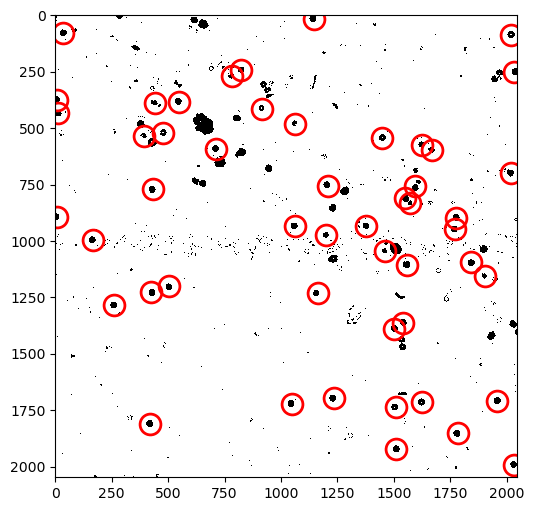

In [78]:
id_example = 50
tp.annotate(features[features.frame==(id_example+1)], img_example);


Frame 166: 56 trajectories present.


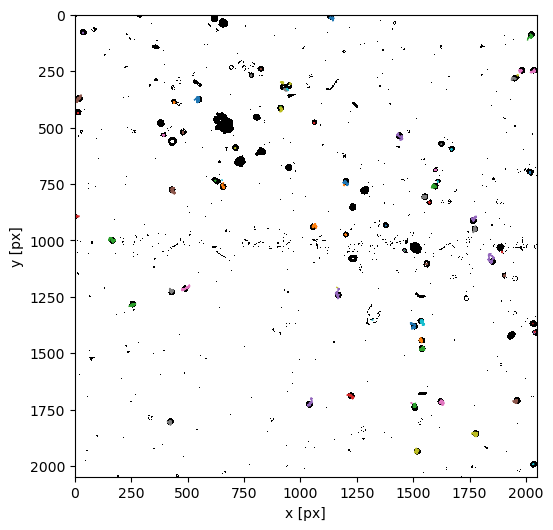

<Axes: xlabel='x [px]', ylabel='y [px]'>

In [79]:
search_range = 20
t = tp.link_df(features, search_range, memory=20)
tp.plot_traj(t, superimpose=frames_thresh[100])

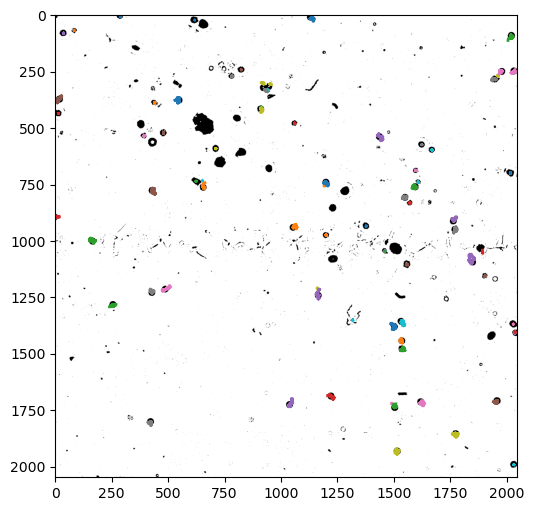

In [80]:
grouped = t.groupby('particle')
plt.imshow(frames_thresh[100], cmap='gray')

for name, group in grouped:
    plt.plot(group['x'], group['y'], linewidth=2)

plt.show()

In [82]:
t

,y,x,frame,particle
0,14.973228,1129.266142,0,0
24,974.669725,1200.009174,0,1
25,997.793774,151.322957,0,2
26,1053.509532,1893.603120,0,3
27,1060.061420,1835.756238,0,4
...,...,...,...,...
8376,687.259259,1598.006944,166,46
8377,742.075499,1192.136752,166,60
8378,738.964871,1608.749415,166,79
8380,767.796034,659.749292,166,71


In [83]:
# Constants for conversion
pixel_to_um = 0.43  # 1 pixel = 0.43 um
time_diff = 10  # Time difference between frames in seconds

# Calculate displacement
t['dx'] = t.groupby('particle')['x'].diff()  # Change in x
t['dy'] = t.groupby('particle')['y'].diff()  # Change in y
t['displacement_pixels'] = np.sqrt(t['dx']**2 + t['dy']**2)

# Convert displacement to micrometers (um)
t['displacement_um'] = t['displacement_pixels'] * pixel_to_um

# Calculate velocity in um/s
t['velocity_um_per_s'] = t['displacement_um'] / time_diff

# Drop intermediate calculation columns
t.drop(['dx', 'dy', 'displacement_pixels'], axis=1, inplace=True)

# Display the final DataFrame
print(t)

                y            x  frame  particle  displacement_um  \
0       14.973228  1129.266142      0         0              NaN   
24     974.669725  1200.009174      0         1              NaN   
25     997.793774   151.322957      0         2              NaN   
26    1053.509532  1893.603120      0         3              NaN   
27    1060.061420  1835.756238      0         4              NaN   
...           ...          ...    ...       ...              ...   
8376   687.259259  1598.006944    166        46         0.121394   
8377   742.075499  1192.136752    166        60         0.173427   
8378   738.964871  1608.749415    166        79         0.152529   
8380   767.796034   659.749292    166        71         0.206395   
8409  1991.384401  2032.775766    166        19         0.120577   

      velocity_um_per_s  
0                   NaN  
24                  NaN  
25                  NaN  
26                  NaN  
27                  NaN  
...                 ...  
8

In [85]:
r = 6.5 * 1e-6  # Radius of the particle in meters
eta = 2  # Viscosity of the fluid in Pa.s

# Convert velocity from um/s to m/s
t['velocity_m_per_s'] = t['velocity_um_per_s'] * 1e-6

# Stokes' Law to calculate force
# F = 6 * pi * eta * r * v
t['force_N'] = 6 * np.pi * eta * r * t['velocity_m_per_s']

# Display the DataFrame with calculated forces
print(t[['velocity_um_per_s', 'velocity_m_per_s', 'force_N']])


      velocity_um_per_s  velocity_m_per_s       force_N
0                   NaN               NaN           NaN
24                  NaN               NaN           NaN
25                  NaN               NaN           NaN
26                  NaN               NaN           NaN
27                  NaN               NaN           NaN
...                 ...               ...           ...
8376           0.012139      1.213941e-08  2.974692e-12
8377           0.017343      1.734272e-08  4.249734e-12
8378           0.015253      1.525294e-08  3.737645e-12
8380           0.020640      2.063953e-08  5.057597e-12
8409           0.012058      1.205774e-08  2.954679e-12

[8410 rows x 3 columns]


In [87]:
def process_tiff_stack(file_name):
    # Open the TIFF stack
    frames = pims.open(file_name)

    # Only use bright field (bf) frames
    bf_frames = frames[::3]

    # Preprocess frames
    frames_thresh = preprocess_foam(bf_frames)

    # Extract features
    filtered_regions_list = [filter_regions(num, img) for num, img in enumerate(frames_thresh)]
    features = pd.DataFrame([item for sublist in filtered_regions_list for item in sublist])

    # Tracking and calculations
    search_range = 20
    t = tp.link_df(features, search_range, memory=20)

    # Constants for conversion
    pixel_to_um = 0.43  # 1 pixel = 0.43 um
    time_diff = 10  # Time difference between frames in seconds

    # Calculate displacement and velocity
    t['dx'] = t.groupby('particle')['x'].diff()
    t['dy'] = t.groupby('particle')['y'].diff()
    t['displacement_pixels'] = np.sqrt(t['dx']**2 + t['dy']**2)
    t['displacement_um'] = t['displacement_pixels'] * pixel_to_um
    t['velocity_um_per_s'] = t['displacement_um'] / time_diff
    t.drop(['dx', 'dy', 'displacement_pixels'], axis=1, inplace=True)

    # Constants for force calculation
    r = 6.5 * 1e-6  # Radius in meters
    eta = 2  # Viscosity in Pa.s

    # Calculate force
    t['velocity_m_per_s'] = t['velocity_um_per_s'] * 1e-6
    t['force_N'] = 6 * np.pi * eta * r * t['velocity_m_per_s']

    return t



In [92]:
# Define the function in this cell
def process_single_file(file):
    file_path = os.path.join(base_dir, file)
    return file, process_tiff_stack(file_path)


In [95]:
base_dir = '/Users/scliu/Dropbox (Personal)/Academics/PhD_phase/Thomson_Lab/local_to_global_pre-print/data/figure_2/stokes/'

# Scan for TIFF files in the directory
tiff_files = [f for f in os.listdir(base_dir) if f.endswith('.tif') or f.endswith('.tiff')]

# Process each TIFF stack and compile results
all_results = {}
for file in tiff_files:
    file_path = os.path.join(base_dir, file)
    all_results[file] = process_tiff_stack(file_path)

# Combine all results into a single DataFrame
combined_results = pd.concat(all_results, names=['file_name', 'index'])

# Save the combined DataFrame
combined_results.to_csv('/Users/scliu/Dropbox (Personal)/Academics/PhD_phase/Thomson_Lab/local_to_global_pre-print/data/figure_2/stokes/combined_results.csv')

Frame 166: 38 trajectories present.


In [96]:
combined_results

y            x  frame  particle  \
file_name          index                                              
5_6.1_65_min_1.tif 0        23.352227     7.728745      0         0   
                   24     1766.083548  1048.681234      0         1   
                   23     1633.861461   196.904282      0         2   
                   22     1631.933248   480.757381      0         3   
                   21     1525.763359  1969.907125      0         4   
...                               ...          ...    ...       ...   
5_6.1_5_min_3.tif  5718    557.212471   189.182448    166        56   
                   5719    678.603846   381.238462    166        39   
                   5720    682.702247  1499.411985    166        13   
                   5712    414.445269   577.656772    166        46   
                   5742   1975.286942  1800.529210    166        33   

                          displacement_um  velocity_um_per_s  \
file_name          index                                       
5_6.1_65_min_1.tif 0                  NaN                NaN   
                   24                 NaN                NaN   
                   23                 NaN                NaN   
                   22                 NaN                NaN   
                   21                 NaN                NaN   
...                                   ...                ...   
5_6.1_5_min_3.tif  5718          1.550393           0.155039   
                   5719          1.580302           0.158030   
                   5720          0.299532           0.029953   
                   5712          0.603301           0.060330   
                   5742          0.753812           0.075381   

                          velocity_m_per_s       force_N  
file_name          index                                  
5_6.1_65_min_1.tif 0                   NaN           NaN  
                   24                  NaN           NaN  
                   23                  NaN           NaN  
                   22                  NaN           NaN  
                   21                  NaN           NaN  
...                                    ...           ...  
5_6.1_5_min_3.tif  5718       1.550393e-07  3.799148e-11  
                   5719       1.580302e-07  3.872438e-11  
                   5720       2.995322e-08  7.339864e-12  
                   5712       6.033010e-08  1.478354e-11  
                   5742       7.538124e-08  1.847174e-11  

[20269 rows x 8 columns]

In [97]:
# Create a list to hold file names and their corresponding average forces
average_forces_data = []

# Iterate over each experiment (file) and calculate the average force
for file, data in all_results.items():
    avg_force = data['force_N'].mean()
    average_forces_data.append({'file_name': file, 'average_force': avg_force})

# Convert the list of dictionaries to a DataFrame
average_forces_df = pd.DataFrame(average_forces_data)

# Display the DataFrame
print(average_forces_df)

              file_name  average_force
0    5_6.1_65_min_1.tif            NaN
1    5_6.1_65_min_3.tif            NaN
2    5_6.1_65_min_2.tif            NaN
3   5_6.1_125_min_3.tif            NaN
4    5_6.1_35_min_3.tif            NaN
5   5_6.1_125_min_2.tif            NaN
6    5_6.1_35_min_2.tif            NaN
7    5_6.1_35_min_1.tif            NaN
8   5_6.1_125_min_1.tif            NaN
9     5_6.1_5_min_1.tif   1.151596e-11
10    5_6.1_5_min_2.tif   1.588772e-11
11    5_6.1_5_min_3.tif   1.567078e-11
